In [1]:
# Module Importations
import matplotlib.pylab as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import yellowbrick
from yellowbrick.regressor import PredictionError, ResidualsPlot

# Module Versioning
print('sklearn ' + sklearn.__version__ + ', ',
      'np ' + np.__version__ + ', ',
      'yellowbrick ' + yellowbrick.__version__) 

sklearn 0.22.2.post1,  np 1.19.4,  yellowbrick 1.2


In [2]:
# Custom Modules
from Source.Data import ntfp_dataset_import as data_load
from Source.Data import ntfp_split_data as split_data
from Source.Features import ntfp_dataset_preprocessing as preprocessing
from Source.Model import ntfp_model_evaluation as evaluation
from Source.Model import ntfp_sklearn_helpers as sklearn_helpers

In [3]:
# Load Dataset
data_filename = 'rul_dataset.pkl'
rul_df = data_load.load_pickled_data(data_filename)

print(rul_df.info())

Loading pickled dataframe started ...
Loading pickled dataframe complete ...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 1 to 100
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Cycles  20631 non-null  int64  
 1   Sn_02   20631 non-null  float64
 2   Sn_03   20631 non-null  float64
 3   Sn_04   20631 non-null  float64
 4   Sn_07   20631 non-null  float64
 5   Sn_09   20631 non-null  float64
 6   Sn_11   20631 non-null  float64
 7   Sn_12   20631 non-null  float64
 8   Sn_14   20631 non-null  float64
 9   Sn_15   20631 non-null  float64
 10  Sn_17   20631 non-null  int64  
 11  Sn_20   20631 non-null  float64
 12  Sn_21   20631 non-null  float64
 13  RUL     20631 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 2.4 MB
None


In [4]:
# Normalise columns into array
normalised_array = preprocessing.standardise_columns(rul_df)

print(normalised_array)
print("Shape:", normalised_array.shape)

[[-1.72172539 -0.13425518 -0.92593596 ... -0.78170979  1.34849274
   1.19442705]
 [-1.06177971  0.21152849 -0.64372587 ... -0.78170979  1.01652793
   1.23692196]
 [-0.66181262 -0.41316559 -0.52595315 ... -2.07309423  0.73989059
   0.50342281]
 ...
 [ 1.47801126  1.94697106  2.13837684 ...  3.09244354 -2.08181033
  -3.29248147]
 [ 1.09804254  2.40366648  1.95505138 ...  1.15536688 -2.91172236
  -2.08507166]
 [ 2.33794049  1.60771161  2.57835793 ...  1.8010591  -2.46910261
  -2.19408035]]
Shape: (20631, 12)


In [5]:
# Calculate slopes for each column
slopes_df, slopes_array = preprocessing.calculate_slopes_all_engines(rul_df, normalised_array)

print(slopes_df.describe())

            Sn_02       Sn_03       Sn_04       Sn_07       Sn_09       Sn_11  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.010975    0.010625    0.012324   -0.011917    0.007100    0.012641   
std      0.002842    0.002459    0.003010    0.003444    0.009205    0.003387   
min      0.005116    0.005192    0.007006   -0.020537   -0.005766    0.006454   
25%      0.009114    0.008862    0.010195   -0.013892   -0.000709    0.010143   
50%      0.010601    0.010617    0.012143   -0.011197    0.003977    0.012485   
75%      0.012328    0.012220    0.013796   -0.009588    0.014261    0.014375   
max      0.018116    0.016361    0.019765   -0.005189    0.026665    0.021425   

            Sn_12       Sn_14       Sn_15       Sn_17       Sn_20       Sn_21  
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean    -0.012249    0.005574    0.011670    0.010988   -0.011533   -0.011540  
std      0.003736    0.009765 

In [6]:
# Order slopes by value
slope_order = preprocessing.return_data_ordered_abs_value(slopes_array, rul_df)


Slope Order: 
['Sn_11' 'Sn_04' 'Sn_12' 'Sn_07' 'Sn_15' 'Sn_21' 'Sn_20' 'Sn_17' 'Sn_02'
 'Sn_03' 'Sn_09' 'Sn_14']


In [7]:
# Visualise slopes for each reading

In [8]:
# Determine [5] most influential columns
data_columns = rul_df.columns.values[1:-1]

slope_slice = slope_order[5:]

data_columns_not_influential = data_columns[slope_slice]

print("Not influential:", data_columns_not_influential)

Not influential: ['Sn_21' 'Sn_20' 'Sn_17' 'Sn_02' 'Sn_03' 'Sn_09' 'Sn_14']


In [9]:
# Remove least influential columns
rul_df = preprocessing.dataset_remove_columns(rul_df, data_columns_not_influential)

print(rul_df)

        Cycles    Sn_04   Sn_07  Sn_11   Sn_12   Sn_15    RUL
Engine                                                       
1            1  1400.60  554.36  47.47  521.66  8.4195 -191.0
1            2  1403.14  553.75  47.49  522.28  8.4318 -190.0
1            3  1404.20  554.26  47.27  522.42  8.4178 -189.0
1            4  1401.87  554.45  47.13  522.86  8.3682 -188.0
1            5  1406.22  554.00  47.28  522.19  8.4294 -187.0
...        ...      ...     ...    ...     ...     ...    ...
100        196  1428.63  551.43  48.07  519.49  8.4956   -4.0
100        197  1433.58  550.86  48.04  519.68  8.5139   -3.0
100        198  1428.18  550.94  48.09  520.01  8.5646   -2.0
100        199  1426.53  550.68  48.39  519.67  8.5389   -1.0
100        200  1432.14  550.79  48.20  519.30  8.5036    0.0

[20631 rows x 7 columns]


In [10]:
# Remove engine cycles (Considered too close to RUL)
cycles = ['Cycles']
rul_df = preprocessing.dataset_remove_columns(rul_df, cycles)

print(rul_df)

          Sn_04   Sn_07  Sn_11   Sn_12   Sn_15    RUL
Engine                                               
1       1400.60  554.36  47.47  521.66  8.4195 -191.0
1       1403.14  553.75  47.49  522.28  8.4318 -190.0
1       1404.20  554.26  47.27  522.42  8.4178 -189.0
1       1401.87  554.45  47.13  522.86  8.3682 -188.0
1       1406.22  554.00  47.28  522.19  8.4294 -187.0
...         ...     ...    ...     ...     ...    ...
100     1428.63  551.43  48.07  519.49  8.4956   -4.0
100     1433.58  550.86  48.04  519.68  8.5139   -3.0
100     1428.18  550.94  48.09  520.01  8.5646   -2.0
100     1426.53  550.68  48.39  519.67  8.5389   -1.0
100     1432.14  550.79  48.20  519.30  8.5036    0.0

[20631 rows x 6 columns]


In [11]:
# Save dataset
filename = 'rul_dataset_preprocessed'
data_load.pickle_data(rul_df, filename)

Pickling dataframe ...
Pickled dataframe to: C:/Developer/nasa-turbofan-failure-prediction/Data/Interim/rul_dataset_preprocessed.pkl


In [12]:
# Split data into training and evaluation sets
training_set, evaluation_set = split_data.split_train_eval(rul_df, 0.2)

Original Data Items: 20631
Training Data Items: 16505
Evaluation Data Items: 4126


In [13]:
# Create RUL Target Dataset

# Training Set as Array
rul_training_data = training_set.drop('RUL', axis = 1).values
rul_training_label = training_set['RUL'].copy().values

#print(rul_training_data)
#print(rul_training_label)

# Evaluation Set as Array
rul_eval_data = evaluation_set.drop('RUL', axis = 1).values
rul_eval_label = evaluation_set['RUL'].copy().values

print(rul_eval_data)
print(rul_eval_label)

[[1408.38    553.06     47.57    521.34      8.4225]
 [1421.3     551.73     48.13    519.87      8.4914]
 [1394.82    554.22     47.01    522.16      8.4054]
 ...
 [1405.88    553.37     47.47    521.1       8.4248]
 [1414.14    553.62     47.4     521.37      8.4602]
 [1399.82    554.85     47.36    521.57      8.4335]]
[-135.   -2. -217. ... -103. -121. -104.]


In [14]:
# Linear Regression Model (Target - RUL)
lin_reg_rul = LinearRegression()
model_name = "LinReg_RUL"

# Train model
lin_reg_rul.fit(rul_training_data, rul_training_label)

# Save model
model_name = sklearn_helpers.name_model(model_name)
sklearn_helpers.save_model(lin_reg_rul, model_name)

# Compute RMSE via cross validation
scores_mse = cross_val_score(lin_reg_rul, rul_training_data, rul_training_label, scoring = "neg_mean_squared_error", cv = 5)
scores_rmse = np.sqrt(-scores_mse)

# Compute MAE via cross validation
scores_mae = cross_val_score(lin_reg_rul, rul_training_data, rul_training_label, scoring = "neg_mean_absolute_error", cv = 5)
scores_mae = -1 * scores_mae

# Visualise cross validation results
print(model_name, "rmse mean (cv):", scores_rmse.mean())
print(model_name, "rmse std (cv):", scores_rmse.std())

print(model_name, "mae mean (cv):", scores_mae.mean())
print(model_name, "mae std (cv):", scores_mae.std())

Save Path: C:/Developer/nasa-turbofan-failure-prediction/Models\PM_LinReg_RUL_2021_02_23-11_40_28.pkl
PM_LinReg_RUL_2021_02_23-11_40_28.pkl rmse mean (cv): 47.0090594599703
PM_LinReg_RUL_2021_02_23-11_40_28.pkl rmse std (cv): 0.387571187210606
PM_LinReg_RUL_2021_02_23-11_40_28.pkl mae mean (cv): 35.77331902605233
PM_LinReg_RUL_2021_02_23-11_40_28.pkl mae std (cv): 0.2870136374160433


In [15]:
# Model Evaluation - Lin Reg RUL

# Describe model coefficients
print("SN_04: ", lin_reg_rul.coef_[0])
print("SN_07: ", lin_reg_rul.coef_[1])
print("SN_11: ", lin_reg_rul.coef_[2])
print("SN_12: ", lin_reg_rul.coef_[3])
print("SN_15: ", lin_reg_rul.coef_[4])

# Evaluate model
rul_prediction = lin_reg_rul.predict(rul_eval_data)
evaluation.evaluate_model(model_name, rul_eval_label, rul_prediction)

SN_04:  1.5116678520113467
SN_07:  -8.954735880044808
SN_11:  59.270500570928334
SN_12:  -12.218682619970426
SN_15:  230.45266670228798
PM_LinReg_RUL_2021_02_23-11_40_28.pkl rmse (Eval): 46.3992179965504
PM_LinReg_RUL_2021_02_23-11_40_28.pkl mae (Eval): 35.69863538647874
PM_LinReg_RUL_2021_02_23-11_40_28.pkl r2 (Eval): 0.5287457275816501


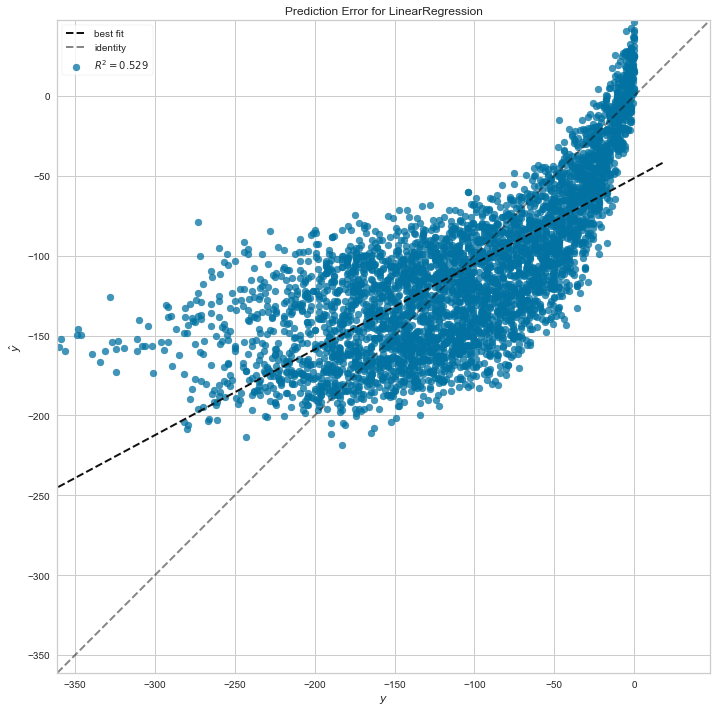

In [16]:
# Visualise Prediction Error (Lin Reg RUL)
fig, ax = plt.subplots(figsize = (14, 12))

# Initialise visualiser
visualiser_error = PredictionError(lin_reg_rul, ax = ax)

# Fit visualiser
visualiser_error.fit(rul_training_data, rul_training_label)
visualiser_error.score(rul_eval_data, rul_eval_label)
visualiser_error.poof()